# Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России: **WAG_C_M.csv**

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, [здесь](http://sophist.hse.ru/exes/tables/WAG_M.htm)

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

### Review criteria
Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для $p, q, P, Q$
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p, q, P, Q$.
7. Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from itertools import product
from scipy import stats

%matplotlib inline

In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
          return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
data = pd.read_csv('datasets/WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## Визуальный анализ ряда

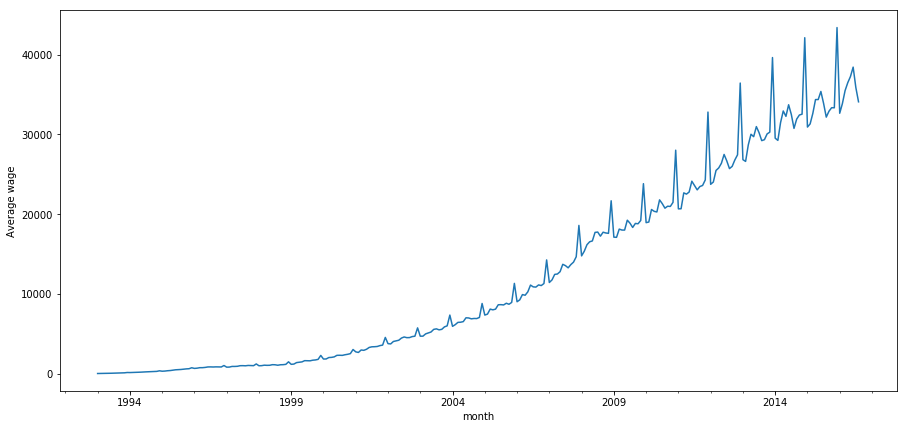

In [4]:
plt.figure(figsize=(15, 7))
data.WAG_C_M.plot()
plt.ylabel('Average wage')
plt.show()

По графику можно заметить довольно сильно возрастающий тренд, годовую сезонность, а также нестационарную дисперсию, следовательно и сам ряд является нестационарным.

Проверим формально ряд на стационарность, а также сделаем STL-декомпозицию:

Критерий Дики-Фуллера: p = 0.992


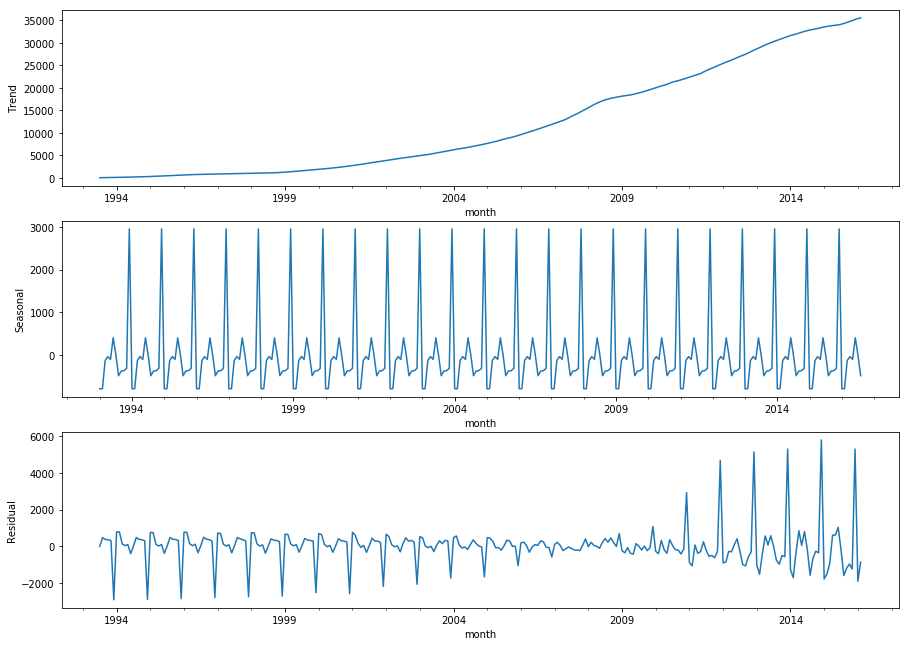

In [5]:
res = sm.tsa.seasonal_decompose(data.WAG_C_M)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15, 11))
res.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
print("Критерий Дики-Фуллера: p = {:.3f}".format(sm.tsa.stattools.adfuller(data.WAG_C_M)[1]))

Критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда.

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263
Критерий Дики-Фуллера: p = 0.697


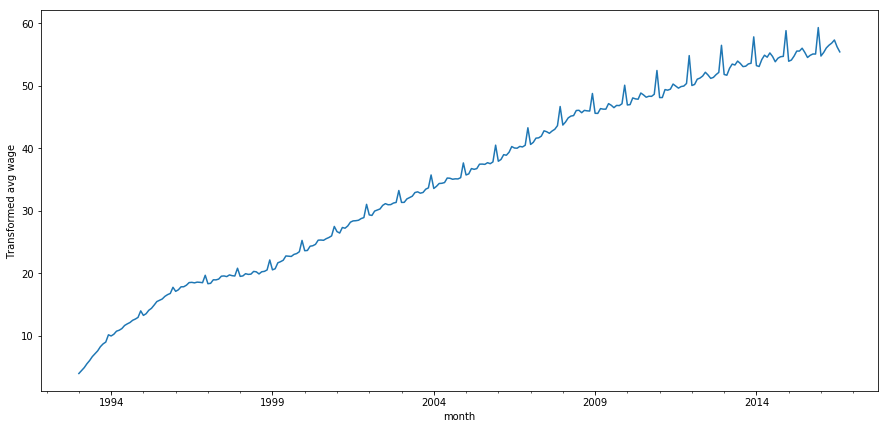

In [6]:
data['avg_wage_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize=(15,7))
data.avg_wage_box.plot()
plt.ylabel('Transformed avg wage')
print('Оптимальный параметр преобразования Бокса-Кокса: {:.3f}'.format(lmbda))
print('Критерий Дики-Фуллера: p = {:.3f}'.format(sm.tsa.stattools.adfuller(data.avg_wage_box)[1]))

По графику и полученному уровню значимости видно, что ряд остался также нестационарным, но дисперсию мы практически стабилизировали.

## Выбор порядка дифференцирования

Попробуем сделать сезонное дифференцирование:

Критерий Дики-Фуллера: p = 0.014697133494791808


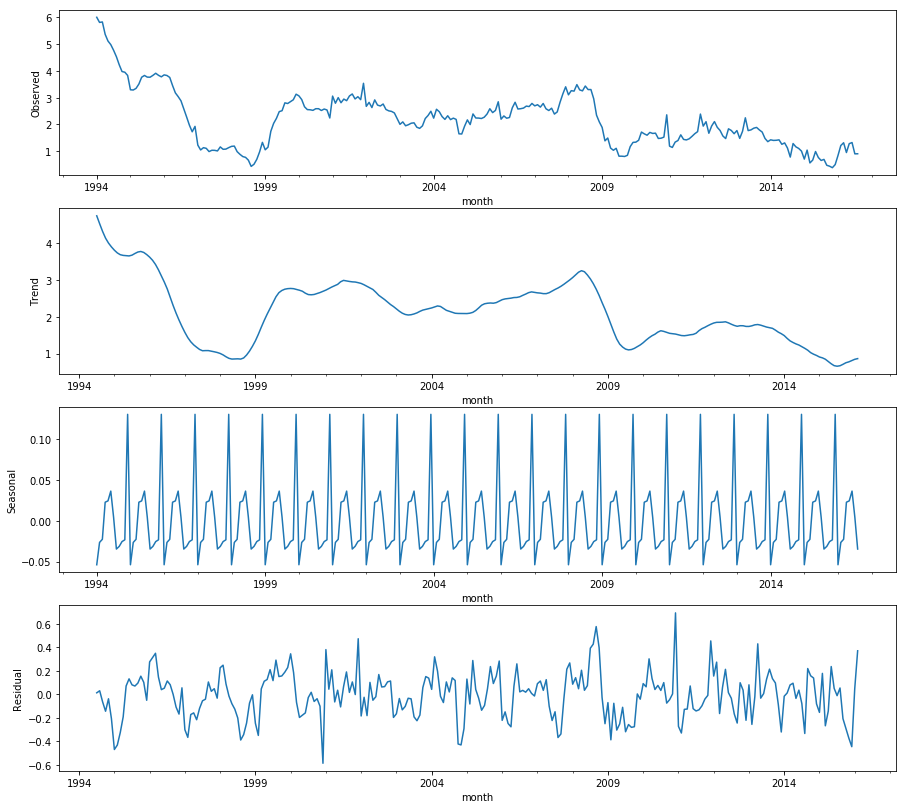

In [7]:
data['avg_wage_box_diff'] = data.avg_wage_box - data.avg_wage_box.shift(12)
res = sm.tsa.seasonal_decompose(data.avg_wage_box_diff[12:])

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(15, 14))
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
res.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
res.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

print('Критерий Дики-Фуллера: p =', sm.tsa.stattools.adfuller(data.avg_wage_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, хотя по графикам можно заменить обратное, поэтому попробуем сделать теперь обычное дифференцирование:

Критерий Дики-Фуллера: p = 5.203603715821631e-08


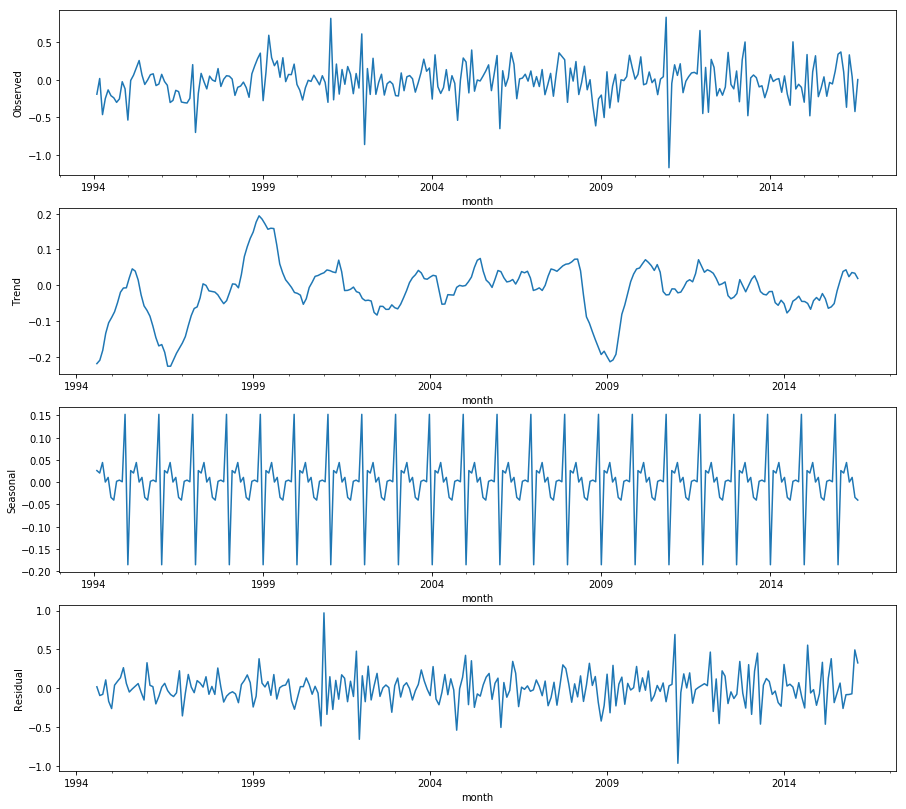

In [8]:
data['avg_wage_box_diff2'] = data.avg_wage_box_diff - data.avg_wage_box_diff.shift(1)
res = sm.tsa.seasonal_decompose(data.avg_wage_box_diff2[13:])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 14))
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
res.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
res.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

print('Критерий Дики-Фуллера: p =', sm.tsa.stattools.adfuller(data.avg_wage_box_diff2[13:])[1])

Гипотеза о нестационарности ряда уверенно отвергается, но в трендовой составляющей можно увидеть резкие скачки, например в 1999 и 2009 годах. Такой скачок в 2009 году мог быть связан с мировым финансовым кризисом.

Попробуем еще раз продифференцировать ряд:

Критерий Дики-Фуллера: p = 1.0159555419596232e-13


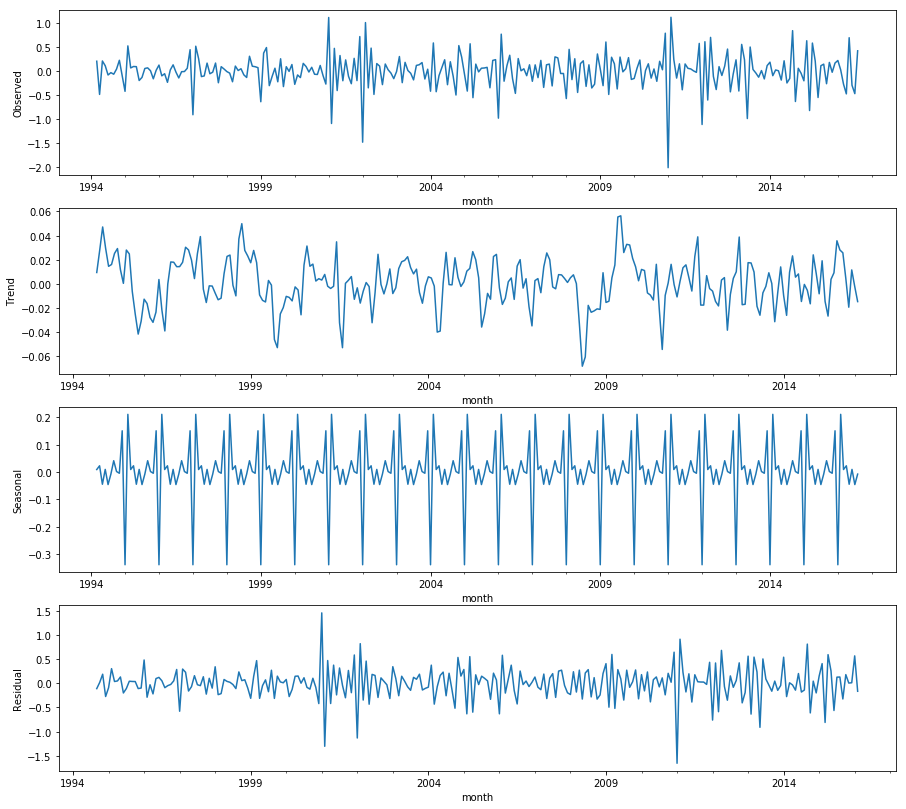

In [9]:
data['avg_wage_box_diff3'] = data.avg_wage_box_diff2 - data.avg_wage_box_diff2.shift(1)
res = sm.tsa.seasonal_decompose(data.avg_wage_box_diff3[14:])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 14))
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
res.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
res.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

print('Критерий Дики-Фуллера: p =', sm.tsa.stattools.adfuller(data.avg_wage_box_diff3[14:])[1])

В итоге можно заменить, что от тренда мы избавились. Увеличение порядка дифференцирования будет лишь его сглаживать.

## Выбор начальных приближений для  p, q, P, Q
Посмотрим на ACF и PACF полученного ряда:

/usr/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


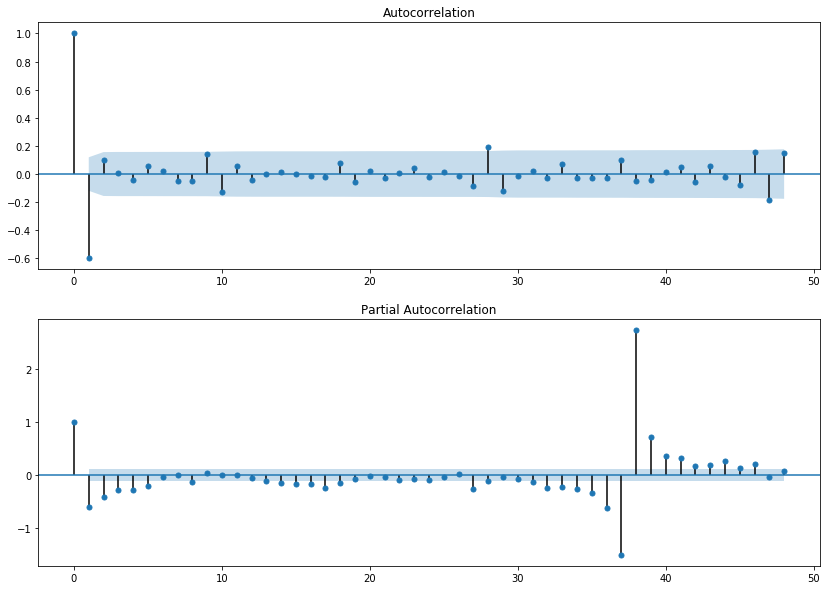

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

sm.graphics.tsa.plot_acf(data.avg_wage_box_diff3[14:], lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data.avg_wage_box_diff3[14:], lags=48, ax=ax2)
plt.show()

Поскольку на коррелограмме не видно сезонных лагов со значимой корреляцией, то $Q*S = 0$ и следовательно $Q = 0$. Что касается параметра $q$, то значимыми несезонными лагами у нас являются значения 1, 28 и 47, но поскольку значения 28 и 47 слишком велики для перебора, то возьмем в качестве начального приближения $q = 1$.    

Посмотрим на коррелограмму частичной автокорреляции. Значимым сезонным лагом является только 36, следовательно $P*S = 36$ и в качестве начального приближения $P$ можно взять $P = 3$ (поскольку период сезона $S = 12$). Для пераметра $p$ возьмем последний значимый несезонный лаг, но поскольку $P$ мы выбрали ненулевое, то наше $p$ не должно превышать периода сезона, т.е. 12. По коррелограмме видно, что в качестве $p$ можно взять $p = 8$.

В итоге получаем следующие параметры модели: $q = 1, p = 8, Q = 0, P = 3$

In [11]:
Qs, qs = [0], range(2)
Ps, ps = range(4), range(9)
D, d = 1, 2
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

72

## Обучение и сравнение моделей-кандидатов

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(data.avg_wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except Exception:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 12min 1s, sys: 13min 54s, total: 25min 55s
Wall time: 7min 54s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
53,"(6, 1, 1, 0)",-0.610384
54,"(6, 1, 2, 0)",0.452068
61,"(7, 1, 1, 0)",1.389568
69,"(8, 1, 1, 0)",1.833798
55,"(6, 1, 3, 0)",2.312340


Видно, что модель с параметрами $p = 6, q = 1, P = 1, Q = 0$ наиболее оптимальная, поскольку у нее наименьшее значение критерия Акаике, а также в ней меньше параметров.

Посмотрим на нашу лучшую модель более детально:

In [14]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       avg_wage_box   No. Observations:                  284
Model:             SARIMAX(6, 2, 1)x(1, 1, 0, 12)   Log Likelihood                   9.305
Date:                            Fri, 21 Sep 2018   AIC                             -0.610
Time:                                    15:19:33   BIC                             31.775
Sample:                                01-01-1993   HQIC                            12.394
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1987      0.052     -3.803      0.000      -0.301      -0.096
ar.L2          0.0234      0.067      0.347      0.729      -0.109       0.155
ar.L3          0.1129      0.063      1.786      0.074      -0.011       0.237
ar.L4          0.1145      0.073      1.560      0.119      -0.029       0.258
ar.L5          0.1786      0.078      2.298      0.022       0.026       0.331
ar.L6          0.1444      0.078      1.840      0.066      -0.009       0.298
ma.L1         -0.9986      0.090    -11.050      0.000      -1.176      -0.821
ar.S.L12      -0.1760      0.045     -3.911      0.000      -0.264      -0.088
sigma2         0.0536      0.005     10.623      0.000       0.044       0.064
===================================================================================
Ljung-Box (Q):                       40.82   Jarque-Bera (JB):                59.12
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Анализ остатков

Критерий Стьюдента: p = 0.10412966036531983
Критерий Дики-Фуллера: p = 1.8339169842132544e-29


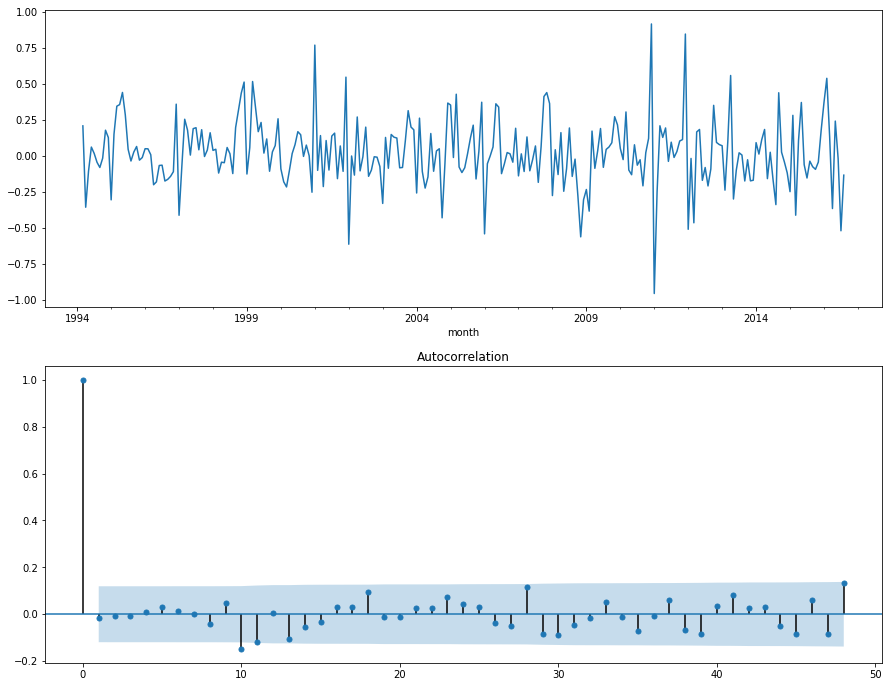

In [15]:
plt.figure(figsize=(15, 12))

plt.subplot(211)
best_model.resid[14:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:], lags=48, ax=ax)

print('Критерий Стьюдента: p =', stats.ttest_1samp(best_model.resid[14:], 0)[1])
print('Критерий Дики-Фуллера: p =', sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

На уровне значимости 0.05 критерий Стьюдента не отвергает гипотезу о равенстве среднего остатков нулю, а также критерий Дики-Фуллера отвергает гипотезу о нестационарности остатков. 

Поскольку достигаемый уровень значимости критерия Льюнга-Бокса равен 0.43 (см. информацию о модели выше), то можно сделать вывод, что остатки неавтокоррелированны. Этот же вывод можно сделать, посмотрев на коррелограмму.

## Прогноз модели
Посмотрим сначала насколько модель хорошо описывает данные:

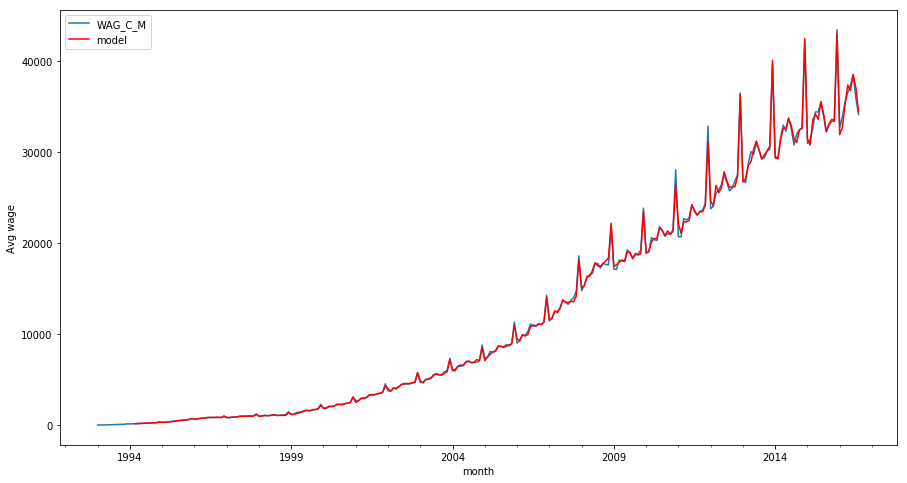

In [16]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15, 8))
data.WAG_C_M.plot()
data.model[14:].plot(color='r')
plt.ylabel('Avg wage')
plt.legend()
plt.show()

По графику видно, что довольно неплохо.

Сделаем прогноз на каждый месяц на два года вперёд от конца данных:

In [17]:
data.index[-1]

Timestamp('2016-08-01 00:00:00')

In [18]:
data.shape

(284, 6)

In [19]:
import datetime
from dateutil.relativedelta import relativedelta
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]

data2 = data[['WAG_C_M']]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

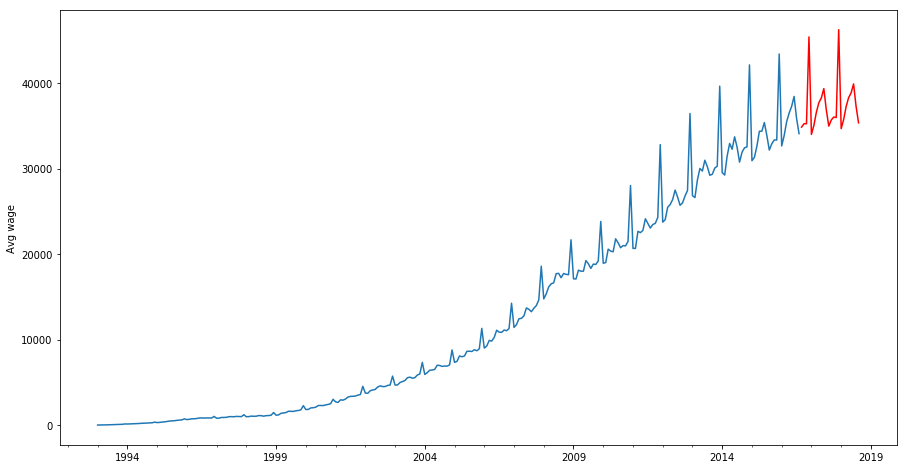

In [20]:
plt.figure(figsize=(15, 8))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Avg wage')
plt.show()

Выведем полученный прогноз, а также реальную среднюю заработную плату, которую можно посмотреть [здесь](http://sophist.hse.ru/exes/tables/WAG_M.htm)

In [21]:
actually_avg_wage = [35843, 35749, 36195, 47554, 34422, 35497, 37899, 39225, 39679, 41454, 38073, 37099, 38047, 38333,
                     38848, 51197, 39017, 40443, 42364, 43381, 44076, 45848, 42413, 41140]

In [22]:
comparison_wage = pd.DataFrame(data2.loc[date_list, 'forecast'])
comparison_wage['actually_avg_wage'] = actually_avg_wage
comparison_wage['diffrence'] = comparison_wage.actually_avg_wage - comparison_wage.forecast
comparison_wage

,forecast,actually_avg_wage,diffrence
2016-09-01,34855.263514,35843,987.736486
2016-10-01,35251.874933,35749,497.125067
2016-11-01,35259.769455,36195,935.230545
2016-12-01,45407.635132,47554,2146.364868
2017-01-01,34006.434040,34422,415.565960
2017-02-01,35077.631572,35497,419.368428
2017-03-01,36619.411990,37899,1279.588010
2017-04-01,37714.560041,39225,1510.439959
2017-05-01,38280.233930,39679,1398.766070
2017-06-01,39364.628530,41454,2089.371470


## Вывод
Полученная модель довольно неплохо предсказывает результат для первых 6 месяцев. Также можно заметить тенденцию к тому, что наша модель всегда недопредсказывает результат. Для первых 6 месяце эта ошибка незначительна (не превышает 1000), для остальных же месяцев разница с фактической средней заработной платой сильно увеличивается (до 5-6 тыс.)